# ARIM-Academy：　機器データ利活用ユースケース（３）
### タイトル：CNNによるSEM画像からのLiB活物質の組成と状態予測
### 機器：走査電子顕微鏡（SEM）
### 分析：CNNによる画像識別　（検証編）

## データセット

**『LIBカソード電極のSEMデータセット』**は、さまざまなLi（Ni、Co、Mn）O 2（NCM）カソードの主な組成（例：333、523、622、および811）とさまざまな状態（例：初期、サイクル前、および100回サイクル）を分類する予測モデルの開発を目的に集められた走査電子顕微鏡（SEM）画像です。電池材料の特性を、画像情報からより迅速かつ正確に評価でき、次世代のリチウムイオン電池の開発に役立ちます。

[1] Oh, J., Yeom, J., Madika, B. et al. Composition and state prediction of lithium-ion cathode via convolutional neural network trained on scanning electron microscopy images. npj Comput Mater 10, 88 (2024). https://doi.org/10.1038/s41524-024-01279-6

<img src="./img/image.png" alt="メインイメージ">

### コードへの接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!pip install efficientnet-pytorch
!git clone https://github.com/ARIM-Usecase/Example_4.git
%cd Example_4

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
#I/Oライブラリ
from tqdm import tqdm

#汎用ライブラリ
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#機械学習/深層学習ライブラリ
import torch
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

from sklearn.metrics import classification_report, confusion_matrix

# utilモジュール
from module.config import get_config
from module.utils import load_test_dataset
from module.utils import loss_fn
from module.utils import optimize_fn

C:\Users\a013662\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\a013662\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 画像初期設定

### I/O初期設定

In [2]:
dataset_name = 'output'
version = 'v1'
config = get_config(dataset_name, version)
save_name = dataset_name + '_' + version

root_dir = config['data_dir']
print("The data lies here =>", root_dir)

The data lies here => ./argmemtated_data/output


In [3]:
seed = config['seed']
np.random.seed(seed)
torch.manual_seed(seed)

### CPU/GPUチェッカー

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## CNNモデルによる予測

### テストデータのロード

In [5]:
test_set = load_test_dataset(config)
test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=1)

### モデル適合

In [6]:
if config['pretrained']:
    model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=12)  # Pre-trained
else:
    model = EfficientNet.from_name('efficientnet-b7', num_classes=12)  # from model

Loaded pretrained weights for efficientnet-b7


### モデル（誤差関数、最適化）の設定

In [7]:
model.to(device)

#構築モデルの読み込み
model.load_state_dict(torch.load(f'./{root_dir}/{save_name}.pth', map_location=device, weights_only=True)['model_state_dict'])

criterion = loss_fn(config)
optimizer = optimize_fn(config, model.parameters())

In [8]:
# Test
with torch.no_grad():
    model.eval()
    result = list()
    y_true = []
    y_pred = []
    
    class_names = ['333', '333_cycled', '333_formation','523'] 

    for X_val_batch, y_val_batch, img_name in tqdm(test_loader):
        inputs, labels = X_val_batch.to(device), y_val_batch.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        preds = test_set.idx2class[int(preds.detach().cpu())]
        labels = test_set.idx2class[int(labels.detach().cpu())]
        result.append([img_name[0], preds, labels, preds==labels])

        y_true.append(labels)
        y_pred.append(preds)

100%|██████████| 40/40 [00:27<00:00,  1.44it/s]


### 分類精度（混同行列）

In [9]:
    # Convert the lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    report = classification_report(y_true, y_pred)
    
    print("Classification Report:")
    print(report)

Classification Report:
               precision    recall  f1-score   support

          333       1.00      1.00      1.00        10
   333_cycled       1.00      1.00      1.00        10
333_formation       1.00      1.00      1.00        10
          523       1.00      1.00      1.00        10

     accuracy                           1.00        40
    macro avg       1.00      1.00      1.00        40
 weighted avg       1.00      1.00      1.00        40



### 可視化（混同行列）

In [10]:
plt.rcParams.update({
    'font.family': 'sans-serif',  # font family
    'font.size': 12,  # font size
    'font.weight': 'normal',  # font weight
    'axes.labelsize': 'large',  # label size
    'axes.titlesize': 'x-large',  # title size
    'xtick.labelsize': 'medium',  # x-axis tick label size
    'ytick.labelsize': 'medium',  # y-axis tick label size
    'legend.fontsize': 'medium',  # legend font size
    'lines.linewidth': 2.0,  # line width
    'figure.figsize': (4, 2),  # figure size in inches
    'figure.dpi': 100,  # figure resolution
    'savefig.dpi': 200,  # save figure resolution
    'axes.grid': False,# grid on or off
    'axes.linewidth':2.0,
    'grid.alpha': 0.5,  # grid transparency
    'grid.linestyle': '--',  # grid line style
    'text.color': 'black',  # text color
    'axes.facecolor': 'white',  # plot background color
    'figure.facecolor': 'white',  # figure background color
})

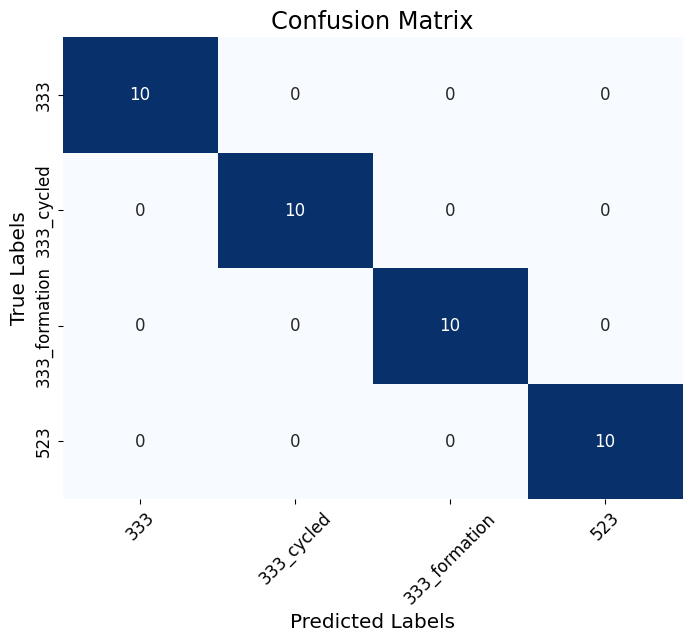

In [11]:
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="Blues", 
                cbar=False, 
                xticklabels=class_names, 
                yticklabels=class_names
                )
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    
    plt.show()


### 結果出力

In [33]:
result = pd.DataFrame(result, columns=['Image Name', 'Prediction', 'Label', 'Result'])
result.index += 1
result.to_csv(f'./{root_dir}/{save_name}.csv')

print(result)
print('Result has been saved.')

                                           Image Name     Prediction  \
1   333_x182y20_ETRI_ 20 kV_SE_HighVac_x500 __1269...            333   
2   333_x222y258_ETRI_ 20 kV_SE_HighVac_x500 __127...            333   
3   333_x265y256_ETRI_ 20 kV_SE_HighVac_x500 __115...            333   
4   333_x276y108_ETRI_ 20 kV_SE_HighVac_x500 __128...            333   
5   333_x31y281_ETRI_ 20 kV_SE_HighVac_x500 __1230...            333   
6   333_x351y41_ETRI_ 20 kV_SE_HighVac_x500 __1188...            333   
7   333_x367y214_ETRI_ 20 kV_SE_HighVac_x500 __123...            333   
8   333_x38y315_ETRI_ 20 kV_SE_HighVac_x500 __1251...            333   
9   333_x75y314_ETRI_ 20 kV_SE_HighVac_x500 __1269...            333   
10  333_x81y208_ETRI_ 20 kV_SE_HighVac_x500 __1334...            333   
11  333_cycled_x133y230_ETRI_ 20 kV_SE_HighVac_x50...     333_cycled   
12  333_cycled_x177y233_ETRI_ 20 kV_SE_HighVac_x50...     333_cycled   
13  333_cycled_x24y253_ETRI_ 20 kV_SE_HighVac_x500...     333_cy